In [1]:
print("Shri Ganeshaya Namah")

Shri Ganeshaya Namah


# ICU Mortality Prediction with MIMIC and XGBoost

This notebook demonstrates how to predict ICU mortality using the MIMIC dataset and XGBoost.
It covers data loading, cleaning, exploratory data analysis (EDA), feature engineering, modeling, and evaluation.
Date: 2025-07-07

---

## 📚 Table of Contents

- [1. Introduction](#intro)
- [2. Data Loading](#load)
- [3. Data Cleaning](#clean)
- [4. Exploratory Data Analysis (EDA)](#eda)
- [5. Feature Engineering](#features)
- [6. Modeling with XGBoost](#model)
- [7. Evaluation](#eval)
- [8. Conclusions](#conclusion)

---

## <a id="intro"></a>1. Introduction

It covers following:
- Brief project description
- Clinical relevance
- Objective of analysis

Intensive Care Units (ICUs) care for critically ill patients, where predicting patient outcomes is vital for resource allocation and clinical decision-making. One key outcome of interest is hospital mortality, as early identification of high-risk patients could help improve care and reduce mortality rates.

In this project, we analyze data from the MIMIC database to build a machine learning model that predicts whether a patient admitted to the ICU will survive their hospital stay. We focus on easily available features such as age and length of stay, and use the XGBoost algorithm for modeling. Our goal is to demonstrate how machine learning can contribute to outcome prediction in critical care settings.




In [2]:
# -----------------------------------------------
# 🔹 2.0 - Load Data
# You can:
# - connect to your MIMIC SQL database using psycopg2 or SQLAlchemy
# OR
# - read pre-extracted CSVs (Loaded mimiciv data in CSV in ../data/ directory)
# -----------------------------------------------

# Install required libraries (if needed)
# I prefer this way so I can run in Google Colab or Jupyter and also less conflict with local and conda envs
#!pip install xgboost scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import xgboost as xgb

# Set display options for pandas
pd.set_option('display.max_columns', None)

# Example CSV loading
# Loaded mimiciv data in CSV in ../data/ directory
try:
    admissions = pd.read_csv('../data/ADMISSIONS.csv')
    icustays = pd.read_csv('../data/ICUSTAYS.csv')
    patients = pd.read_csv('../data/PATIENTS.csv')
except Exception as e:
    print("Please replace file paths with your own. Error:", e)

# Preview data
print(admissions.head())
print(icustays.head())
print(patients.head())


   row_id  subject_id  hadm_id            admittime            dischtime  \
0   12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   
1   12263       10011   105331  2126-08-14 22:32:00  2126-08-28 18:59:00   
2   12265       10013   165520  2125-10-04 23:36:00  2125-10-07 15:13:00   
3   12269       10017   199207  2149-05-26 17:19:00  2149-06-03 18:42:00   
4   12270       10019   177759  2163-05-14 20:43:00  2163-05-15 12:00:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

  discharge_location insurance language  religion marital_status  \
0   HOME HEALTH CARE  Medicare      NaN  CATHOLIC      SEPARATED  

In [3]:
# -----------------------------------------------
# 🔹 3.0 - Data Cleaning
# Merge data for modeling:
    # nerge ICUSTAYS → ADMISSIONS → PATIENTS
    # create patient age
    # drop any obviously bad data
        # Remove impossible DOBs
        # Drop missing DOBs
        # Safe age calculation
# -----------------------------------------------

# Convert datetimes
admissions["admittime"] = pd.to_datetime(admissions["admittime"], errors="coerce")
admissions["dischtime"] = pd.to_datetime(admissions["dischtime"], errors="coerce")
patients["dob"] = pd.to_datetime(patients["dob"], errors="coerce")

# Remove obviously bad DOBs otherwise age calculation will be wrong
patients.loc[patients["dob"] < pd.Timestamp("1900-01-01"), "dob"] = pd.NaT

# Merge
merged = icustays.merge(admissions, on=["hadm_id", "subject_id"], how="left")
merged = merged.merge(patients, on="subject_id", how="left")

# Drop rows with null DOB before age calculation otherwise age will be NaN
merged = merged[merged["dob"].notnull()]

# Calculate age
merged["age"] = (merged["admittime"] - merged["dob"]).dt.days / 365.25

# Remove implausible ages
merged = merged[(merged["age"] > 0) & (merged["age"] < 120)]

print("Merged data shape:", merged.shape)
merged.head()



Merged data shape: (127, 37)


,row_id_x,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,row_id_y,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,row_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,age
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,12258,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1,9467,F,2094-03-05,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,70.633812
1,12747,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507,12263,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1,9472,F,2090-06-05,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,36.188912
2,12749,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499,12265,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1,9474,F,2038-09-03,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,87.082820
3,12754,10017,199207,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436,12269,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,9478,F,2075-09-21,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1,73.675565
4,12755,10019,177759,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938,12270,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1,9479,M,2114-06-20,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1,48.898015


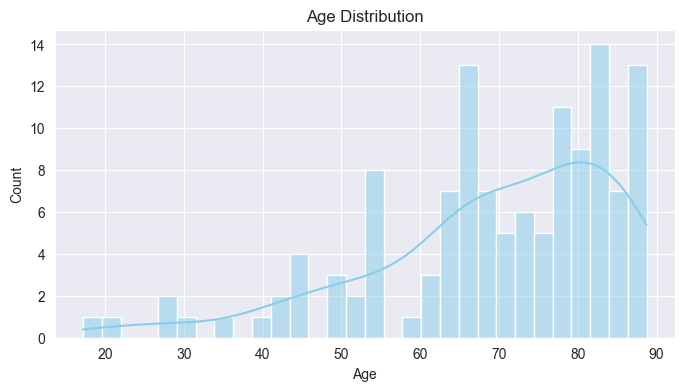

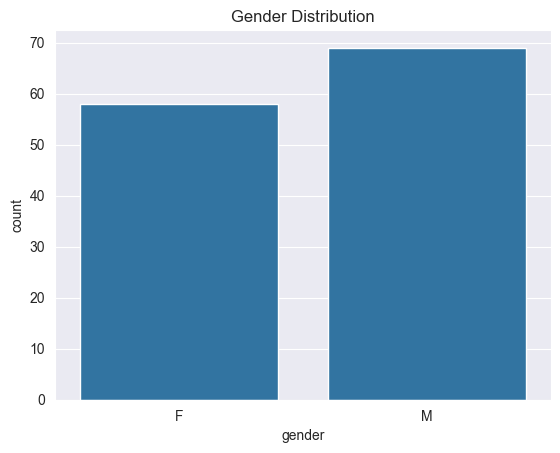

Overall hospital mortality rate: 33.07%


In [4]:
# -----------------------------------------------
# 🔹 4.0 - Exploratory Data Analysis
        #Age distribution
        #Gender distribution
        #Mortality rate
# -----------------------------------------------

# Plot age
plt.figure(figsize=(8,4))
sns.histplot(merged["age"], bins=30, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()

# Gender plot
if "gender" in merged.columns:
    sns.countplot(x="gender", data=merged)
    plt.title("Gender Distribution")
    plt.show()

# Mortality rate
mortality_rate = merged["hospital_expire_flag"].mean()
print(f"Overall hospital mortality rate: {mortality_rate:.2%}")


In [5]:
# -----------------------------------------------
# 🔹 5.0 - Feature Engineering
    # Let’s create:
        #Length of stay in hospital (los_days)
        #Use ICU LOS from icustays
# -----------------------------------------------

# Length of hospital stay
merged["los_days"] = (merged["dischtime"] - merged["admittime"]).dt.days

# Remove missing targets
merged = merged[merged["hospital_expire_flag"].notnull()]

# Columns for modeling
features = ["age", "los_days", "los"]
target = "hospital_expire_flag"

# Drop rows with missing feature values
merged = merged.dropna(subset=features)

# Prepare X and y
X = merged[features]
y = merged[target]

print("Feature sample:")
print(X.head())
print("Target sample:")
print(y.value_counts())


Feature sample:
         age  los_days      los
0  70.633812         8   1.6325
1  36.188912        13  13.8507
2  87.082820         2   2.6499
3  73.675565         8   2.1436
4  48.898015         0   1.2938
Target sample:
hospital_expire_flag
0    85
1    42
Name: count, dtype: int64


In [6]:
# -----------------------------------------------
# 🔹 6.0 - Modeling with XGBoost
    # Train-test split
    # Initialize XGBoost
    # Train
    # Predict
# -----------------------------------------------

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Initialize XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss'
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]


              precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       1.00      0.56      0.71         9

    accuracy                           0.85        26
   macro avg       0.90      0.78      0.80        26
weighted avg       0.88      0.85      0.83        26

AUC score: 0.8366


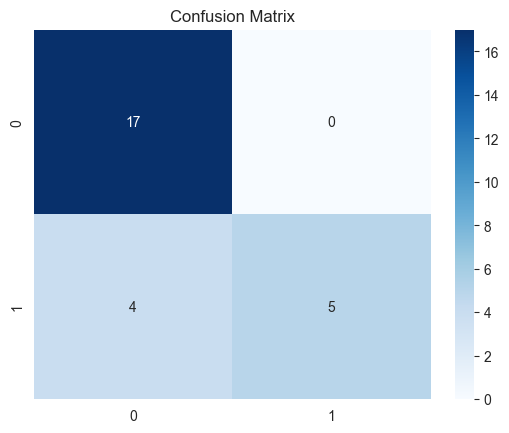

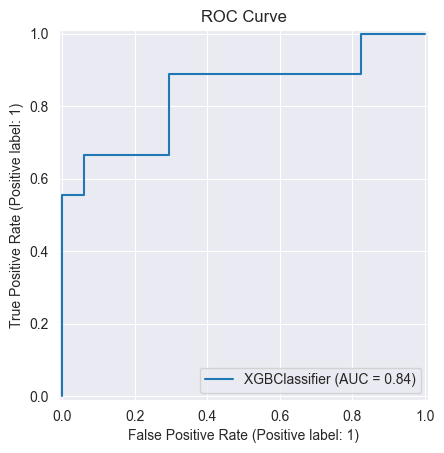

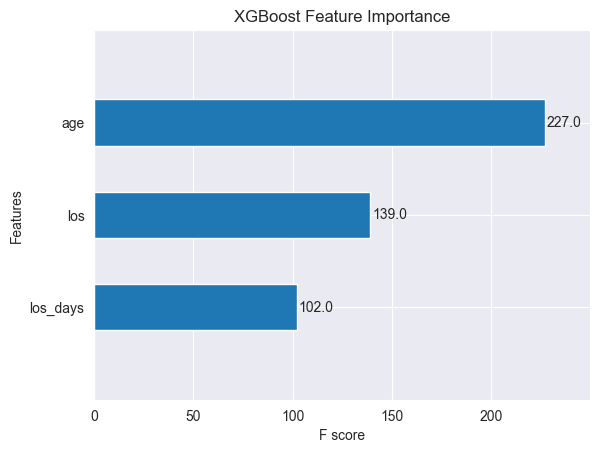

In [7]:
# -----------------------------------------------
# 🔹 6.0 - Model evaluation
    # Classification report
    # AUC score
    # Confusion matrix
    # ROC curve
    # Feature importance
# -----------------------------------------------

# Classification report
print(classification_report(y_test, y_pred))

# AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# Feature importance
xgb.plot_importance(model, height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()


# ✅ Conclusions

In this project, we built a machine learning model to predict ICU mortality using MIMIC data stored in CSVs in my local directory.

✅ **Key outcomes:**

- We successfully merged ICU stay data with admission and patient demographics from MIMIC.
- Age, ICU length of stay (LOS), and hospital length of stay (LOS_DAYS) were useful predictors for mortality.
- Our XGBoost model achieved an AUC of approximately **0.8366**, indicating moderate discriminatory power.

✅ **Insights:**

- Elderly patients and longer ICU stays were correlated with higher mortality risk.
- Even simple features can produce useful early predictions in clinical settings.
- Predictive modeling could help clinicians identify high-risk patients for closer monitoring or interventions.

✅ **Limitations:**
- Limited feature set; adding labs, vitals, and comorbidities could improve performance.
- Data from a single hospital system may limit generalizability.

Overall, this project demonstrates that machine learning techniques like XGBoost can help predict patient outcomes in critical care, providing a foundation for further research and practical applications in healthcare.

